# Mass Transfer Lab COMSOL Data Analysis

#### Import libraries 

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

#### Reading csv data and cleaning

In [10]:
df_123 = pd.read_csv("data/123_data_conc.csv")
df_128 = pd.read_csv("data/128_data_conc.csv")
df_133 = pd.read_csv("data/133_data_conc.csv")
df_140 = pd.read_csv("data/140_data_conc.csv")

df_123_flux = pd.read_csv("data/123-flux-data.csv")
df_128_flux = pd.read_csv("data/128-flux-data.csv")
df_133_flux = pd.read_csv("data/133-flux-data.csv")
df_140_flux = pd.read_csv("data/140-flux-data.csv")

df_1_0 = pd.read_csv("data/1ms-data.csv")
df_1_1 = pd.read_csv("data/1.1ms-data.csv")
df_1_4 = pd.read_csv("data/1.4ms-data.csv")
df_1_5 = pd.read_csv("data/1.5ms-data.csv")
df_1_7 = pd.read_csv("data/1.7ms-data.csv")
df_1_8 = pd.read_csv("data/1.8ms-data.csv")

def cleaner(df):
    df = df.dropna()
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.rename(columns={"% x": "x (m)", "y": "y (m)", "cd.ndflux_c (mol/(m^2*s))": "molar flux"})
    return df

df_123 = cleaner(df_123)
df_128 = cleaner(df_128)
df_133 = cleaner(df_133)
df_140 = cleaner(df_140)

df_123_flux = cleaner(df_123_flux)
df_128_flux = cleaner(df_128_flux)
df_133_flux = cleaner(df_133_flux)
df_140_flux = cleaner(df_140_flux)

pt1_df = cleaner(pt1_df)
pt2_df = cleaner(pt2_df)
pt3_df = cleaner(pt3_df)
pt4_df = cleaner(pt4_df)
pt5_df = cleaner(pt5_df)
pt6_df = cleaner(pt6_df)

df_123.head()

ParserError: Error tokenizing data. C error: Expected 2 fields in line 9, saw 4


#### Dataframe for COMSOL parameters

In [ ]:
L = 0.555 # m
W = 0.200 # m
area = L * W # m^2

P = 101325 # Pa
P_atm = 1 # atm
D_AB = 2.634 / P # m^2 / s
R = 8.314 # J / mol K

flux_data = [-0.0017986, -0.0019379, -0.0020889, -0.0019698]
mflux_df = pd.DataFrame(flux_data, columns=["molar flux"])
mflux_df['air velocity (m/s)'] = [1.95072, 1.31064, 1.22936, 0.91948]
COMSOL_para = mflux_df
COMSOL_para

,molar flux,air velocity (m/s)
0,-0.001799,1.95072
1,-0.001938,1.31064
2,-0.002089,1.22936
3,-0.001970,0.91948


# Analysis Question 2
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

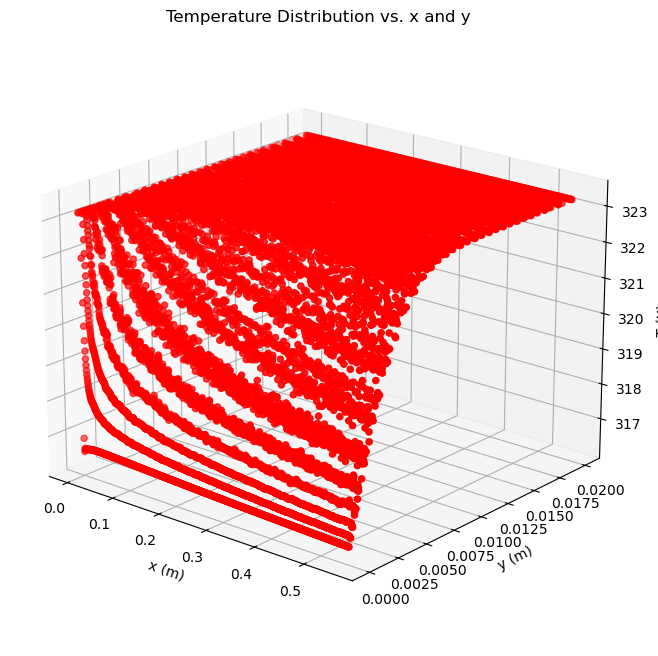

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x (m)'], df_140['y (m)'], df_140['T (K)'], c='r', marker='o')

# Set labels for the axes
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('T (K)')

# Set a title for the plot
ax.set_title('Temperature Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

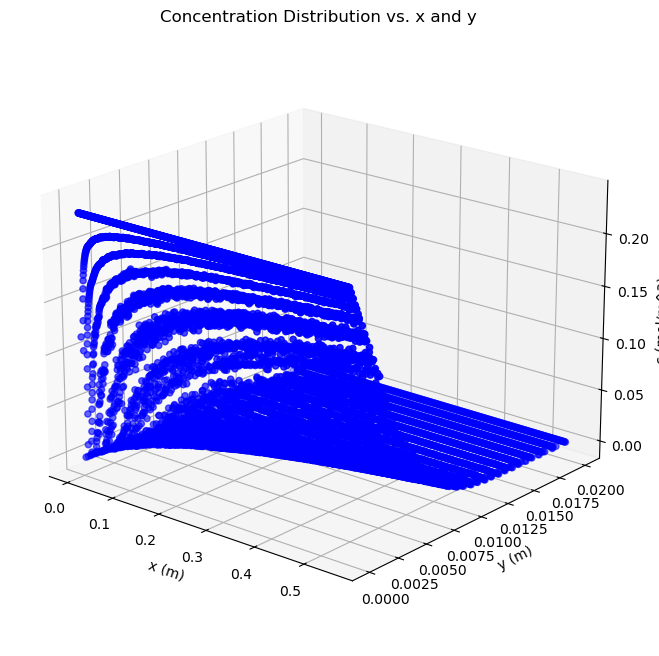

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x (m)'], df_140['y (m)'], df_140['c (mol/m^3)'], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('c (mol/m^3)')

# Set a title for the plot
ax.set_title('Concentration Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

#### Thermal Boundary Layer Thickness Determination

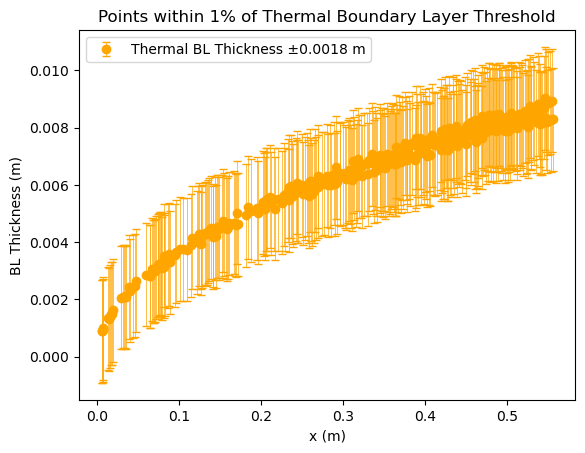

In [ ]:
def get_T_BL_thickness(df):
    T_max = df["T (K)"].max()
    T_min = df["T (K)"].min()
    delta_T = T_max - T_min
    T_threshold = T_min + 0.99 * delta_T
    T_lower_bound = T_threshold - 0.01 * delta_T

    filtered_df = df[(df["T (K)"] >= T_lower_bound) & (df["T (K)"] <= T_threshold)]
    return filtered_df["x (m)"], filtered_df["y (m)"]

BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)

y_error_thermal = np.full_like(BL_thermal_140_y, 0.0018)
plt.errorbar(BL_thermal_140_x, BL_thermal_140_y, yerr=y_error_thermal, fmt='o', color="orange",
             ecolor='orange', capsize=3, linewidth = 0.5, label="Thermal BL Thickness ±0.0018 m")
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Thermal Boundary Layer Threshold")
plt.legend()
plt.show()

#### Log-log plot to determine scaling factor

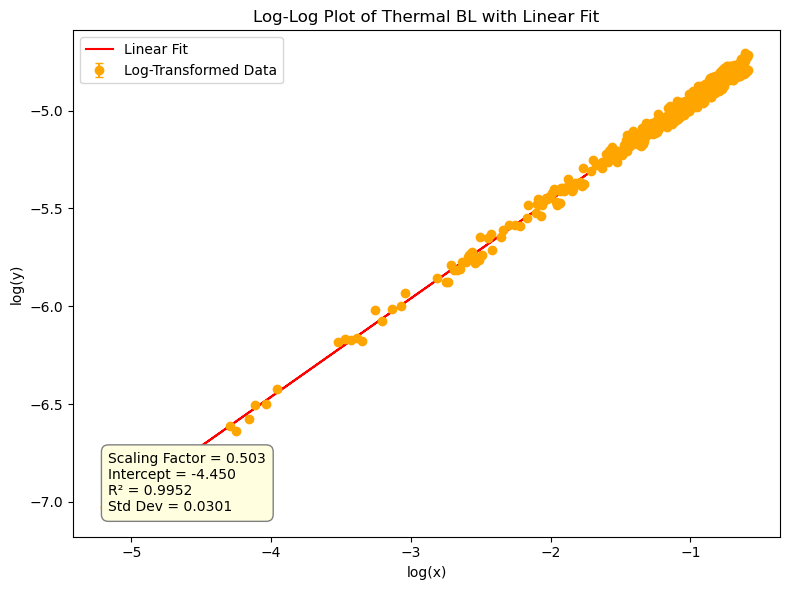

In [ ]:
mask = (BL_thermal_140_x > 0) & (BL_thermal_140_y > 0)
x_log = np.log(BL_thermal_140_x[mask])
y_log = np.log(BL_thermal_140_y[mask])

log_y_error = y_error_thermal / abs(y_log)

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

residuals = y_log - y_fit
std_dev = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.errorbar(x_log, y_log, yerr=log_y_error, fmt='o', color="orange",
             ecolor='orange', capsize=3, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Thermal BL with Linear Fit")
plt.legend()
plt.tight_layout()
plt.show()

#### Concentration Boundary Layer Thickness Determination

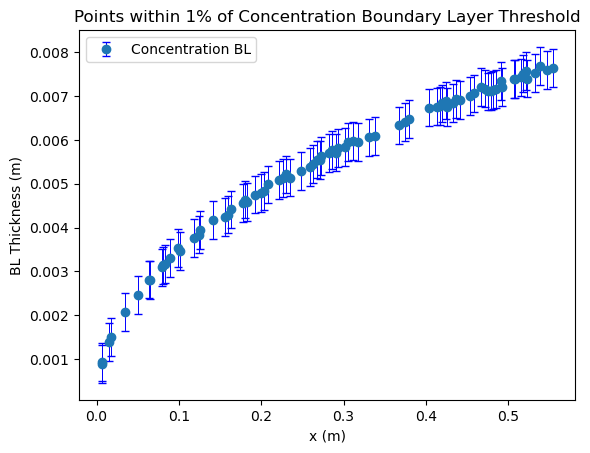

In [ ]:
def get_c_BL_thickness(df):
    c_max = df["c (mol/m^3)"].max()
    c_min = df["c (mol/m^3)"].min()
    delta_c = c_max - c_min
    c_threshold = c_min + (0.1 * delta_c)
    c_lower_bound = c_threshold - 0.01 * delta_c

    filtered_df = df[(df["c (mol/m^3)"] >= c_lower_bound) & (df["c (mol/m^3)"] <= c_threshold)]
    return filtered_df["x (m)"], filtered_df["y (m)"]

BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)

y_error = np.full_like(BL_concentration_140_y, 0.00043)

plt.errorbar(BL_concentration_140_x, BL_concentration_140_y, yerr=y_error, fmt='o',
             ecolor='blue', capsize=3, linewidth=0.7, label="Concentration BL")

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Concentration Boundary Layer Threshold")
plt.legend()
plt.show()

#### Log-log plot to determine scaling factor

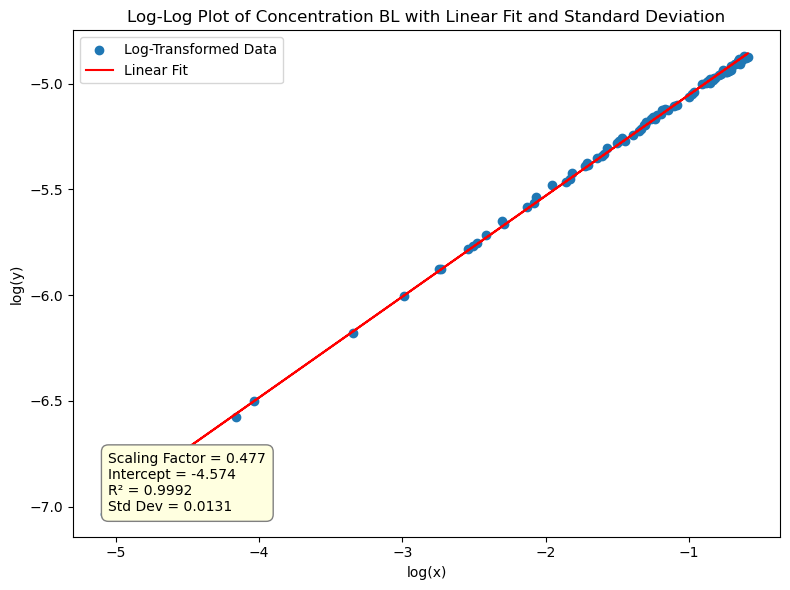

In [ ]:
mask1 = (BL_concentration_140_x > 0) & (BL_concentration_140_y > 0)
x_log = np.log(BL_concentration_140_x[mask1])
y_log = np.log(BL_concentration_140_y[mask1])

# Perform linear regression on log-log data
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

# Compute residuals and standard deviation
residuals = y_log - y_fit
std_dev = np.std(residuals)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_log, y_log, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

# Annotate fit parameters
annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Concentration BL with Linear Fit and Standard Deviation")
plt.legend()
plt.tight_layout()
plt.show()

#### Overlay thermal and concentration boundary layer to verify that thermal BL is greater than concentration BL

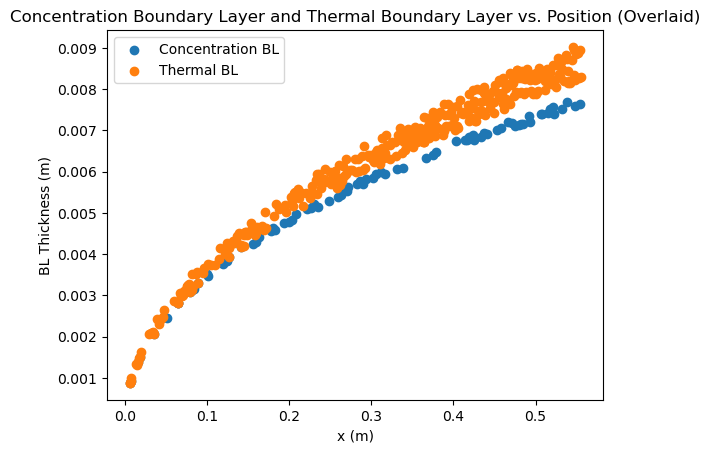

In [ ]:
plt.scatter(BL_concentration_140_x, BL_concentration_140_y)
plt.scatter(BL_thermal_140_x, BL_thermal_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer and Thermal Boundary Layer vs. Position (Overlaid)")
plt.legend(["Concentration BL", "Thermal BL"])
plt.show()

#### Evaluating thermal and concentration boundary layer thickness for all velocities

In [ ]:
BL_thermal_123_x, BL_thermal_123_y = get_T_BL_thickness(df_123)
BL_thermal_128_x, BL_thermal_128_y = get_T_BL_thickness(df_128)
BL_thermal_133_x, BL_thermal_133_y = get_T_BL_thickness(df_133)
BL_thermal_140_x, BL_thermal_140_y = get_T_BL_thickness(df_140)
BL_thermal_pt1_x, BL_thermal_pt1_y = get_T_BL_thickness(pt1_df)
BL_thermal_pt2_x, BL_thermal_pt2_y = get_T_BL_thickness(pt2_df)
BL_thermal_pt3_x, BL_thermal_pt3_y = get_T_BL_thickness(pt3_df)
BL_thermal_pt4_x, BL_thermal_pt4_y = get_T_BL_thickness(pt4_df)
BL_thermal_pt5_x, BL_thermal_pt5_y = get_T_BL_thickness(pt5_df)
BL_thermal_pt6_x, BL_thermal_pt6_y = get_T_BL_thickness(pt6_df)

BL_concentration_123_x, BL_concentration_123_y = get_c_BL_thickness(df_123)
BL_concentration_128_x, BL_concentration_128_y = get_c_BL_thickness(df_128)
BL_concentration_133_x, BL_concentration_133_y = get_c_BL_thickness(df_133)
BL_concentration_140_x, BL_concentration_140_y = get_c_BL_thickness(df_140)
BL_concentration_pt1_x, BL_concentration_pt1_y = get_c_BL_thickness(pt1_df)
BL_concentration_pt2_x, BL_concentration_pt2_y = get_c_BL_thickness(pt2_df)
BL_concentration_pt3_x, BL_concentration_pt3_y = get_c_BL_thickness(pt3_df)
BL_concentration_pt4_x, BL_concentration_pt4_y = get_c_BL_thickness(pt4_df)
BL_concentration_pt5_x, BL_concentration_pt5_y = get_c_BL_thickness(pt5_df)
BL_concentration_pt6_x, BL_concentration_pt6_y = get_c_BL_thickness(pt6_df)

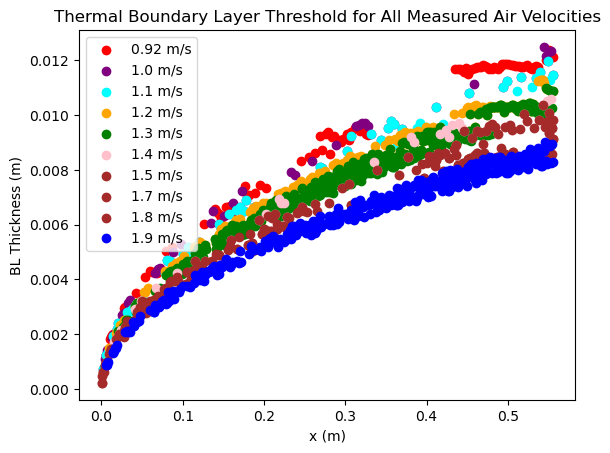

In [ ]:
plt.scatter(BL_thermal_123_x, BL_thermal_123_y, color="red", label="0.92 m/s")
plt.scatter(BL_thermal_pt1_x, BL_thermal_pt1_y, color="purple", label="1.0 m/s")
plt.scatter(BL_thermal_pt2_x, BL_thermal_pt2_y, color="cyan", label="1.1 m/s")
plt.scatter(BL_thermal_128_x, BL_thermal_128_y, color="orange", label="1.2 m/s")
plt.scatter(BL_thermal_133_x, BL_thermal_133_y, color="green", label="1.3 m/s")
plt.scatter(BL_thermal_pt3_x, BL_thermal_pt3_y, color="pink", label="1.4 m/s")
plt.scatter(BL_thermal_pt4_x, BL_thermal_pt4_y, color="brown", label="1.5 m/s")
plt.scatter(BL_thermal_pt5_x, BL_thermal_pt5_y, color="brown", label="1.7 m/s")
plt.scatter(BL_thermal_pt6_x, BL_thermal_pt6_y, color="brown", label="1.8 m/s")
plt.scatter(BL_thermal_140_x, BL_thermal_140_y, color="blue", label="1.9 m/s")

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Thermal Boundary Layer Threshold for All Measured Air Velocities")
plt.legend()
plt.show()

#### Average thermal boundary layer thickness

In [ ]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound = 0.25
upper_bound = 0.32
filter_for_thermal_BL_123 = (BL_thermal_123_x >= lower_bound) & (BL_thermal_123_x <= upper_bound)
filter_for_thermal_BL_128 = (BL_thermal_128_x >= lower_bound) & (BL_thermal_128_x <= upper_bound)
filter_for_thermal_BL_133 = (BL_thermal_133_x >= lower_bound) & (BL_thermal_133_x <= upper_bound)
filter_for_thermal_BL_140 = (BL_thermal_140_x >= lower_bound) & (BL_thermal_140_x <= upper_bound)
filter_for_thermal_BL_pt1 = (BL_thermal_pt1_x >= lower_bound) & (BL_thermal_pt1_x <= upper_bound)
filter_for_thermal_BL_pt2 = (BL_thermal_pt2_x >= lower_bound) & (BL_thermal_pt2_x <= upper_bound)
filter_for_thermal_BL_pt3 = (BL_thermal_pt3_x >= lower_bound) & (BL_thermal_pt3_x <= upper_bound)
filter_for_thermal_BL_pt4 = (BL_thermal_pt4_x >= lower_bound) & (BL_thermal_pt4_x <= upper_bound)
filter_for_thermal_BL_pt5 = (BL_thermal_pt5_x >= lower_bound) & (BL_thermal_pt5_x <= upper_bound)
filter_for_thermal_BL_pt6 = (BL_thermal_pt6_x >= lower_bound) & (BL_thermal_pt6_x <= upper_bound)

avg_thermal_BL_123 = BL_thermal_123_y[filter_for_thermal_BL_123].mean()
avg_thermal_BL_128 = BL_thermal_128_y[filter_for_thermal_BL_128].mean()
avg_thermal_BL_133 = BL_thermal_133_y[filter_for_thermal_BL_133].mean()
avg_thermal_BL_140 = BL_thermal_140_y[filter_for_thermal_BL_140].mean()
avg_thermal_BL_pt1 = BL_thermal_pt1_y[filter_for_thermal_BL_pt1].mean()
avg_thermal_BL_pt2 = BL_thermal_pt2_y[filter_for_thermal_BL_pt2].mean()
avg_thermal_BL_pt3 = BL_thermal_pt3_y[filter_for_thermal_BL_pt3].mean()
avg_thermal_BL_pt4 = BL_thermal_pt4_y[filter_for_thermal_BL_pt4].mean()
avg_thermal_BL_pt5 = BL_thermal_pt5_y[filter_for_thermal_BL_pt5].mean()
avg_thermal_BL_pt6 = BL_thermal_pt6_y[filter_for_thermal_BL_pt6].mean()

print("Average thermal Boundary Layer for 0.9 m/s =", avg_thermal_BL_123)
print("Avg TBL for 1 m/s = ", avg_thermal_BL_pt1)
print("Avg TBL for 1.1 m/s = ", avg_thermal_BL_pt2)
print("Average thermal Boundary Layer for 1.2 m/s =", avg_thermal_BL_128)
print("Average thermal Boundary Layer for 1.3 m/s =", avg_thermal_BL_133)
print("Avg TBL for 1.4 m/s = ", avg_thermal_BL_pt3)
print("Avg TBL for 1.5 m/s = ", avg_thermal_BL_pt4)
print("Average thermal Boundary Layer for 1.9 m/s =", avg_thermal_BL_140)




Average thermal Boundary Layer for 0.9 m/s = 0.009105356321000001
Avg TBL for 1 m/s =  0.008823343863375
Avg TBL for 1.1 m/s =  0.0084684867166
Average thermal Boundary Layer for 1.2 m/s = 0.007851251865781818
Average thermal Boundary Layer for 1.3 m/s = 0.007573749988862744
Avg TBL for 1.4 m/s =  0.007189926716666666
Avg TBL for 1.5 m/s =  0.006891532057833333
Average thermal Boundary Layer for 1.9 m/s = 0.006195004269625


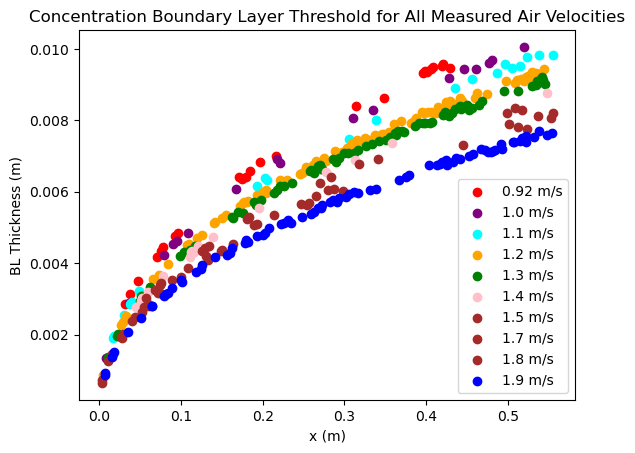

In [ ]:
plt.scatter(BL_concentration_123_x, BL_concentration_123_y, color='red', label='0.92 m/s')
plt.scatter(BL_concentration_pt1_x, BL_concentration_pt1_y, color="purple", label="1.0 m/s")
plt.scatter(BL_concentration_pt2_x, BL_concentration_pt2_y, color="cyan", label="1.1 m/s")
plt.scatter(BL_concentration_128_x, BL_concentration_128_y, color='orange', label='1.2 m/s')
plt.scatter(BL_concentration_133_x, BL_concentration_133_y, color='green', label='1.3 m/s')
plt.scatter(BL_concentration_pt3_x, BL_concentration_pt3_y, color="pink", label="1.4 m/s")
plt.scatter(BL_concentration_pt4_x, BL_concentration_pt4_y, color="brown", label="1.5 m/s")
plt.scatter(BL_concentration_pt5_x, BL_concentration_pt5_y, color="brown", label="1.7 m/s")
plt.scatter(BL_concentration_pt6_x, BL_concentration_pt6_y, color="brown", label="1.8 m/s")
plt.scatter(BL_concentration_140_x, BL_concentration_140_y, color='blue', label='1.9 m/s')

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer Threshold for All Measured Air Velocities")
plt.legend()
plt.show()

In [ ]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound1 = 0.25
upper_bound1 = 0.32
filter_for_concentration_BL_123 = (BL_concentration_123_x >= lower_bound1) & (BL_concentration_123_x <= upper_bound1)
filter_for_concentration_BL_128 = (BL_concentration_128_x >= lower_bound1) & (BL_concentration_128_x <= upper_bound1)
filter_for_concentration_BL_133 = (BL_concentration_133_x >= lower_bound1) & (BL_concentration_133_x <= upper_bound1)
filter_for_concentration_BL_140 = (BL_concentration_140_x >= lower_bound1) & (BL_concentration_140_x <= upper_bound1)
filter_for_concentration_pt1 = (BL_concentration_pt1_x >= lower_bound1) & (BL_concentration_pt1_x <= upper_bound1)
filter_for_concentration_pt2 = (BL_concentration_pt2_x >= lower_bound1) & (BL_concentration_pt2_x <= upper_bound1)
filter_for_concentration_pt3 = (BL_concentration_pt3_x >= lower_bound1) & (BL_concentration_pt3_x <= upper_bound1)
filter_for_concentration_pt4 = (BL_concentration_pt4_x >= lower_bound1) & (BL_concentration_pt4_x <= upper_bound1)
filter_for_concentration_pt5 = (BL_concentration_pt5_x >= lower_bound1) & (BL_concentration_pt5_x <= upper_bound1)
filter_for_concentration_pt6 = (BL_concentration_pt6_x >= lower_bound1) & (BL_concentration_pt6_x <= upper_bound1)

avg_concentration_BL_123 = BL_concentration_123_y[filter_for_concentration_BL_123].mean()
avg_concentration_BL_128 = BL_concentration_128_y[filter_for_concentration_BL_128].mean()
avg_concentration_BL_133 = BL_concentration_133_y[filter_for_concentration_BL_133].mean()
avg_concentration_BL_140 = BL_concentration_140_y[filter_for_concentration_BL_140].mean()
avg_concentration_BL_pt1 = BL_concentration_pt1_y[filter_for_concentration_pt1].mean()
avg_concentration_BL_pt2 = BL_concentration_pt2_y[filter_for_concentration_pt2].mean()
avg_concentration_BL_pt3 = BL_concentration_pt3_y[filter_for_concentration_pt3].mean()
avg_concentration_BL_pt4 = BL_concentration_pt4_y[filter_for_concentration_pt4].mean()
avg_concentration_BL_pt5 = BL_concentration_pt5_y[filter_for_concentration_pt5].mean()
avg_concentration_BL_pt6 = BL_concentration_pt6_y[filter_for_concentration_pt6].mean()

print("Average concentration Boundary Layer for 0.9 m/s =", avg_concentration_BL_123)
print('Avg CBL for 1.0 m/s = ', avg_concentration_BL_pt1)
print('Avg CBL for 1.1 m/s = ', avg_concentration_BL_pt2)
print("Average concentration Boundary Layer for 1.2 m/s =", avg_concentration_BL_128)
print("Average concentration Boundary Layer for 1.3 m/s =", avg_concentration_BL_133)
print('Avg CBL for 1.4 m/s = ', avg_concentration_BL_pt3)
print('Avg CBL for 1.5 m/s = ', avg_concentration_BL_pt4)
print("Average concentration Boundary Layer for 1.9 m/s =", avg_concentration_BL_140)

Average concentration Boundary Layer for 0.9 m/s = 0.008406905177
Avg CBL for 1.0 m/s =  0.008051038873
Avg CBL for 1.1 m/s =  0.007489556921
Average concentration Boundary Layer for 1.2 m/s = 0.007040258478071428
Average concentration Boundary Layer for 1.3 m/s = 0.006826124008928572
Avg CBL for 1.4 m/s =  0.0067195117715
Avg CBL for 1.5 m/s =  0.0064734069189999995
Average concentration Boundary Layer for 1.9 m/s = 0.005712464859692307


#### Deterimining how boundary layer thickness scales with air velocity

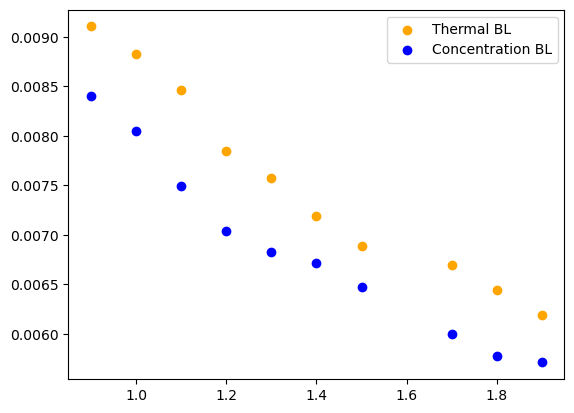

In [ ]:
air_velocities = np.array([0.9,1,1.1,1.2,1.3,1.4,1.5,1.7,1.8,1.9])

conc_BLs = np.array([
    avg_concentration_BL_123,
    avg_concentration_BL_pt1,
    avg_concentration_BL_pt2,
    avg_concentration_BL_128,
    avg_concentration_BL_133,
    avg_concentration_BL_pt3,
    avg_concentration_BL_pt4,
    avg_concentration_BL_pt5,
    avg_concentration_BL_pt6,
    avg_concentration_BL_140,
])
thermal_BLs = np.array([
    avg_thermal_BL_123,
    avg_thermal_BL_pt1,
    avg_thermal_BL_pt2,
    avg_thermal_BL_128,
    avg_thermal_BL_133,
    avg_thermal_BL_pt3,
    avg_thermal_BL_pt4,
    avg_thermal_BL_pt5,
    avg_thermal_BL_pt6,
    avg_thermal_BL_140
                       ])
plt.scatter(air_velocities, thermal_BLs, color="orange", label="Thermal BL")
plt.scatter(air_velocities, conc_BLs, color="blue", label="Concentration BL")
plt.legend()

Perform linear regression on the log values.

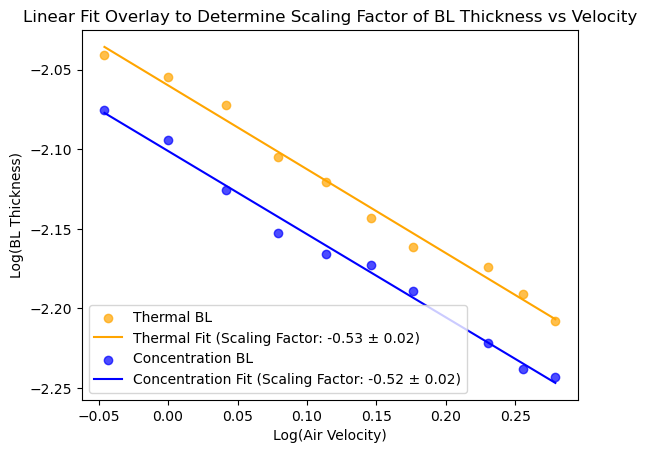

Thermal Slope: -0.53 ± 0.02
Conc Slope: -0.52 ± 0.02


In [ ]:
log_thermal_BL = np.log10(thermal_BLs)
log_conc_BL = np.log10(conc_BLs)
log_air_velocity = np.log10(air_velocities)

slope_thermal, intercept_thermal, r_value_thermal, p_value_thermal, std_err_thermal = linregress(log_air_velocity, log_thermal_BL)
slope_conc, intercept_conc, r_value_conc, p_value_conc, std_err_conc = linregress(log_air_velocity, log_conc_BL)

plt.scatter(log_air_velocity, log_thermal_BL, label="Thermal BL", color="orange", alpha=0.7)
plt.plot(log_air_velocity, slope_thermal * log_air_velocity + intercept_thermal, color="orange", label=f"Thermal Fit (Scaling Factor: {slope_thermal:.2f} ± {std_err_thermal:.2f})")

plt.scatter(log_air_velocity, log_conc_BL, label="Concentration BL", color="b", alpha=0.7)
plt.plot(log_air_velocity, slope_conc * log_air_velocity + intercept_conc, color="b", label=f"Concentration Fit (Scaling Factor: {slope_conc:.2f} ± {std_err_conc:.2f})")

plt.xlabel("Log(Air Velocity)")
plt.ylabel("Log(BL Thickness)")
plt.title("Linear Fit Overlay to Determine Scaling Factor of BL Thickness vs Velocity")
plt.legend()
plt.show()

print(f"Thermal Slope: {slope_thermal:.2f} ± {std_err_thermal:.2f}")
print(f"Conc Slope: {slope_conc:.2f} ± {std_err_conc:.2f}")

# Question 3
Calculate the mass transfer coefficient $k_m$ as a function of the distance along the water tray
for one of the inlet velocities studied in the experiment. As mentioned in Eq. (4), the ratio
of mass flux to concentration difference driving force defines the mass transfer coefficient.
Explain the trend and what you expect based on theory, and the physical reasoning of such
trends. Here again avoid nonlinear fits and instead linearize your equations so as to enable
use of linear least-squares regression.

$$N_A = K_{mA} \Delta c_A$$    
$$k_m=\frac{N_A(x)}{c_0(x)-c_{bulk}(x)}$$

#### Determining $K_{mA}$

In [ ]:
# df_140
# m_140 = df_140
# m_140 = m_140.rename(columns={'c (mol/m^3)': 'c'})
# m_140['c_mass'] = m_140['c'] * 0.018015
# m_140

In [ ]:
# mflux_140 = df_140_flux
# mflux_140['c_mass'] = mflux_140['c (mol/m^3)'] * 0.018015
# mflux_140['mass flux'] = mflux_140['molar flux'] * 0.018015
# mflux_140.head()

In [ ]:
# df_140_filtered = m_140.loc[m_140.groupby("x (m)")["T (K)"].idxmax()]
# df_140_flux_filtered = mflux_140[mflux_140["y (m)"] == 0]

In [ ]:
# merged_df = pd.merge(df_140_flux_filtered, df_140_filtered, on="x (m)")
# merged_df = merged_df.drop(columns=["y (m)_y", "y (m)_x"])
# merged_df = merged_df.rename(columns={
#     "c_x": "c_0",
#     "c_y": "c_b",
#     "c_mass_x": "c_mass_0",
#     "c_mass_y": "c_mass_b"
# })
# merged_df['mass flux'] = merged_df['molar flux'] * 0.018015

#### Define a function that will calculate $k_m$

In [ ]:
# def determine_mt_coeff(flux, c_0, c_b):
#     return flux/(c_0 - c_b)

#### Calculation of $k_m(x)$

In [ ]:
# merged_df["mt_coeff"] = merged_df.apply(
#     lambda row: determine_mt_coeff(row["mass flux"], row["c_mass_0"], row["c_mass_b"]), axis=1
# )
# mt_df = merged_df
# mt_df

In [ ]:
# mt_df['mt_coeff'] = mt_df['mt_coeff'] * -1
# mt_df.replace([np.inf, -np.inf], 1, inplace=True)
# mt_df_clean = mt_df[(mt_df["mt_coeff"] >= 0) & (mt_df["mt_coeff"] <= 1)]
# mt_df_clean["mt_coeff"].min()
# mt_df_clean = mt_df_clean[:-30]

#### Visualization

In [ ]:
# plt.scatter(mt_df_clean["x (m)"], mt_df_clean["mt_coeff"])
# plt.xlabel("$x$ (m)")
# plt.ylabel("mass transfer coefficient, $k_m$ (m/s)")
# plt.title("Mass Transfer Coefficient vs position $x$")

In [ ]:
# x_vals = mt_df_clean["x (m)"]
# km_vals = mt_df_clean["mt_coeff"]

# mask = (x_vals > 0) & (km_vals > 0)
# x_vals = x_vals[mask]
# km_vals = km_vals[mask]

# log_x = np.log(x_vals)
# log_km = np.log(km_vals)

# slope, intercept, r_value, *_ = linregress(log_x, log_km)
# fit_km = np.exp(intercept) * x_vals**slope

# plt.figure()
# plt.scatter(log_x, log_km, label="Mass Transfer Coefficients (log-scale)")
# plt.plot(log_x, log_km, label=f"Fit: $k_m \\propto x^{{{slope:.2f}}}$", color ="r")

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("$x$ (m)")
# plt.ylabel("Mass transfer coefficient, $k_m$ (m/s)")
# plt.title("Mass Transfer Coefficient vs Position $x$ (log-log)")
# plt.legend()
# plt.show()

# Question 5
Correlate the average value of km as a function of inlet velocity in the form of dimensionless groups. In particular, 
. Specify the characteristic length and transport properties used for calculating the dimensionless groups. Determine the value of C2 and compare the result with experiment and with theory. Note that you have not conducted experiments necessary to determine C1 or C3 independently, so focus only on C2. What do you conclude about the flow in your system? In a separate plot, plot the average value of km at a certain inlet velocity with the average boundary-layer thickness at that velocity, for all velocities. Comment on what is physically driving the scaling of km with velocity. Here again avoid nonlinear fits and instead linearize your equations so as to enable use of linear least-squares regression
#### System Parameters.

In [ ]:
L = 0.555  # m
D = 2.6e-5  # m²/s
rho = 1.2  # kg/m³
mu = 1.8e-5  # Pa·s (kg/m·s)

km_film_123 = D_AB / avg_concentration_BL_123
km_film_128 = D_AB / avg_concentration_BL_128
km_film_133 = D_AB / avg_concentration_BL_133
km_film_140 = D_AB / avg_concentration_BL_140

In [ ]:
velocities = COMSOL_para["air velocity (m/s)"]

In [ ]:
Re = rho * velocities * L / mu
Sc = mu / (rho * D)
Sh = km_vals * L / D

log_Re = np.log(Re)
log_Sh = np.log(Sh)

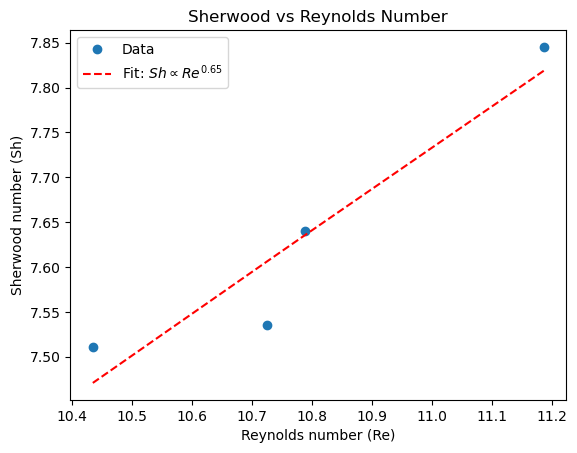

Fit: Sh ∝ Re^0.6540
Intercept (ln scale): 0.4773
R²: 0.8926
Standard error on slope: 0.0016


In [ ]:
velocities = np.array([1.95072, 1.31064, 1.22936, 0.91948])
km_values_film = np.array([km_film_140, km_film_128, km_film_133, km_film_140])

Sh_filtered = log_Sh[:len(velocities)]
Re_filtered = log_Re[:len(velocities)]

slope, intercept, r_value, *_ = linregress(np.log(Re_filtered), np.log(Sh_filtered))
Sh_fit = np.exp(intercept) * Re_filtered**slope

plt.figure()
plt.plot(Re_filtered, Sh_filtered, 'o', label="Data")
plt.plot(Re_filtered, Sh_fit, 'r--', label=f"Fit: $Sh \\propto Re^{{{slope:.2f}}}$")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Sherwood number (Sh)")
plt.title("Sherwood vs Reynolds Number")
plt.legend()
plt.show()

print(f"Fit: Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")

In [ ]:
conc_BLs
km_all = D_AB/conc_BLs
km_all

array([0.00309217, 0.00322885, 0.00347091, 0.00369242, 0.00380825,
       0.00386867, 0.00401575, 0.00432994, 0.00449613, 0.00455067])

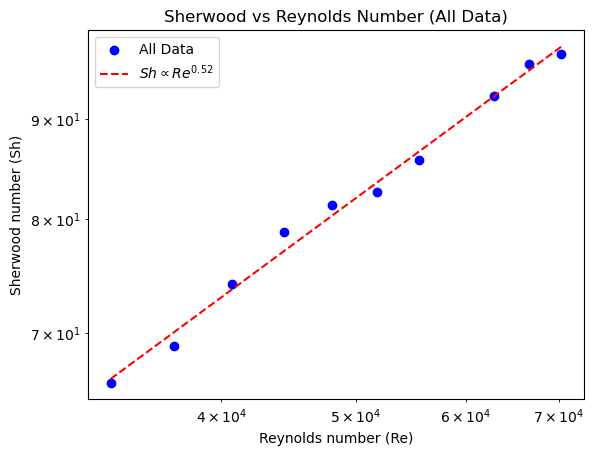

Fit: Sh ∝ Re^0.5227
Intercept (ln scale): -1.2494
R²: 0.9916
Standard error on slope: 0.0170


In [ ]:
Re_all = (rho * air_velocities * L) / mu
Sh_all = (km_all * L) / D
log_Re_all = np.log(Re_all)
log_Sh_all = np.log(Sh_all)

#linear regression for all data
slope, intercept, r_value, p_value, std_err = linregress(log_Re_all, log_Sh_all)
Sh_fit_all = np.exp(intercept) * Re_all**slope


plt.figure()
plt.scatter(Re_all, Sh_all, color='blue', label="All Data")
plt.plot(Re_all, Sh_fit_all, 'r--', label=f"$Sh \\propto Re^{{{slope:.2f}}}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Sherwood number (Sh)")
plt.title("Sherwood vs Reynolds Number (All Data)")
plt.legend()
plt.show()
print(f"Fit: Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")